In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import joblib
import json
from tqdm.notebook import tqdm
from tensorflow import keras
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

In [2]:
descriptions_path = '../data/modified_captions.json'
features_path = '../features/features_vgg16.p'  # output = 4096
# features_path = '../features/features_inceptionv3.p' # output = 2048
# features_path = '../features/features_xception.p' # output = 2048
# features_path = '../features/features_resnet50.p' # output = 2048

In [3]:
with open(descriptions_path, 'r') as file:
    descriptions = json.load(file)

In [4]:
features = joblib.load(features_path)

In [5]:
all_captions = []
for img, caps in descriptions.items():
    for cap in caps:
        all_captions.append(cap)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

8764

In [6]:
max_length = max(len(cap.split()) for cap in all_captions)
max_length

34

In [7]:
split = 0.9

train_images = list(descriptions.keys())[:int(len(descriptions) * split)]
test_images = list(descriptions.keys())[int(len(descriptions) * split):]

In [8]:
len(train_images), len(test_images)

(7281, 810)

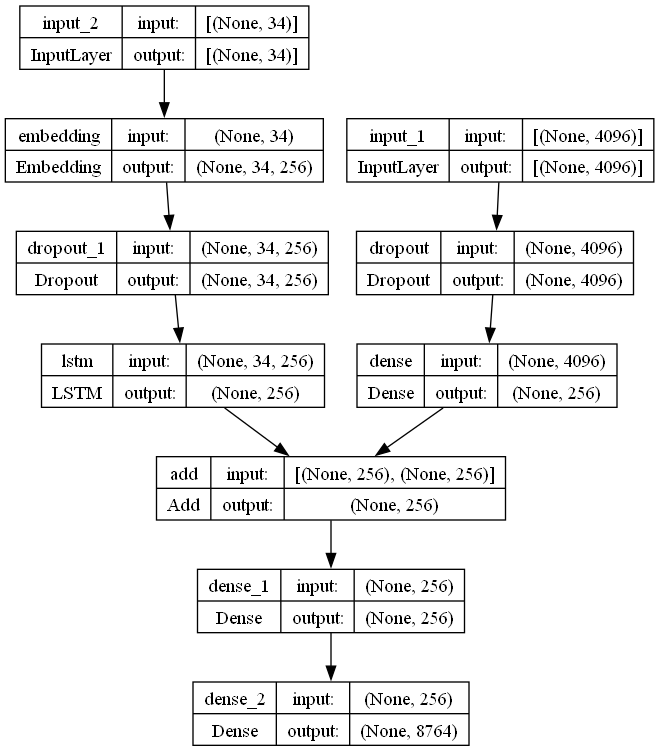

In [9]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [10]:
def data_generator(data, descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data:
            n += 1
            captions = descriptions[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [11]:
epochs = 50
batch_size = 16
steps = len(train_images) // batch_size

for i in range(epochs):
    generator = data_generator(train_images, descriptions, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps)

455/455 [==============================] - 395s 869ms/step - loss: 1.6973


In [12]:
model.save('model.h5')

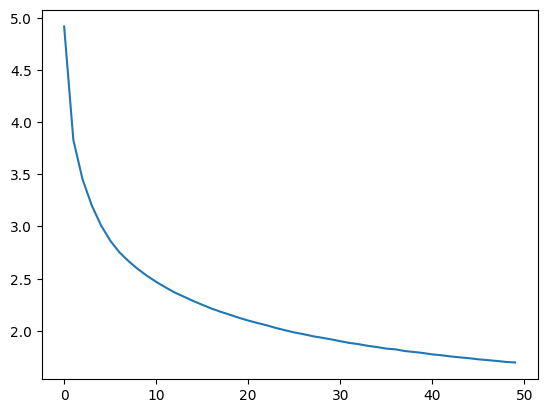

In [32]:
loss = [4.9160, 3.8294, 3.4518, 3.2023, 3.0116, 2.8657, 2.7530, 2.6679, 2.5930, 2.5279, 2.4698, 2.4176, 2.3682, 2.3281, 2.2878, 2.2503, 2.2141, 2.1833, 2.1547, 2.1256, 2.0991, 2.0756, 2.0536, 2.0282, 2.0064,
        1.9853, 1.9686, 1.9494, 1.9343, 1.9191, 1.9012, 1.8847, 1.8728, 1.8568, 1.8449, 1.8303, 1.8233, 1.8071, 1.7980, 1.7880, 1.7748, 1.7666, 1.7553, 1.7463, 1.7382, 1.7277, 1.7201, 1.7120, 1.7027, 1.6973]
plt.plot(loss)

In [9]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    predicted_caption = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([predicted_caption])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = index_to_word(y_pred, tokenizer)
        if word is None:
            break
        predicted_caption += " " + word
        if word == 'end':
            break

    return predicted_caption

In [39]:
actual = []
predicted = []

scores1 = []
scores2 = []
scores3 = []

for img in tqdm(test_images):
    captions = descriptions[img]

    y_pred = predict_caption(model, features[img], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)

    val1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    val2 = corpus_bleu(actual, predicted, weights=(0.75, 0.25, 0, 0))
    val3 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    scores1.append(val1)
    scores2.append(val2)
    scores3.append(val3)

  0%|          | 0/810 [00:00<?, ?it/s]

C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


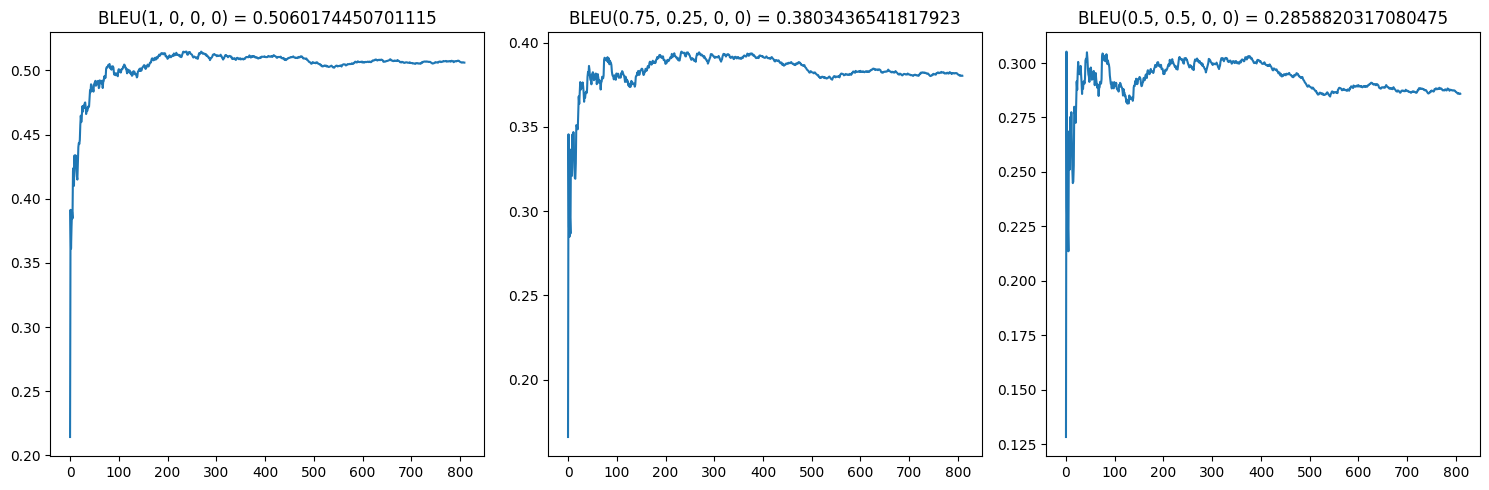

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(scores1)
axes[0].set_title('BLEU(1, 0, 0, 0) = ' + str(scores1[-1]))

axes[1].plot(scores2)
axes[1].set_title('BLEU(0.75, 0.25, 0, 0) = ' + str(scores2[-1]))

axes[2].plot(scores3)
axes[2].set_title('BLEU(0.5, 0.5, 0, 0) = ' + str(scores3[-1]))

plt.tight_layout()
plt.show()

In [87]:
from PIL import Image

PATH = '../data/Images'

def generate_caption(image_name):
    img_path = os.path.join(PATH, image_name)
    image = Image.open(img_path)
    captions = descriptions[image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption[6:-4])
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    y_pred = y_pred[6:-4]
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.axis('off')
    plt.imshow(image)
    # plt.text(0, -20, y_pred, bbox=dict(fill=False, edgecolor='black', linewidth=2))
    plt.text(0.5, -0.03, y_pred, ha='center', va='top',
             transform=plt.gca().transAxes,)

---------------------Actual---------------------
black dog jumps horizontal bar in grassy feild
black dog jumps hurdle in grassy area
black dog jumps over pole on green grass
medium sized black dog jumps over gate
the black dog is jumping over the white pole in the grass
--------------------Predicted--------------------
black and white dog jumps over fence


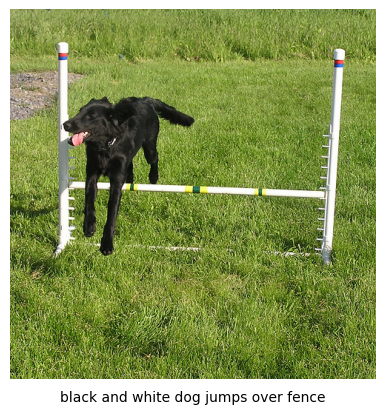

In [95]:
generate_caption("2784625888_71a421e171.jpg")